## В данном блокноте проведем анализ `SQuAD 2.0`

In [ ]:
import re
import string

import numpy as np

from datasets import load_dataset #Загрузка датасета 

from transformers import AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikita\AppData\Roaming\nltk_data...


In [4]:
OUT_DIR_FOR_DATA = "./prep_datasets/"

In [5]:
#Загружаем датасет
datasetSQUAD2 = load_dataset("rajpurkar/squad_v2", cache_dir="./cdatasets")

val_dataset = datasetSQUAD2['validation'] 
train_dataset = datasetSQUAD2['train']

print(val_dataset.info)
print(train_dataset.info)

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='squad_v2', config_name='squad_v2', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=116742930, num_examples=130319, shard_lengths=None, dataset_name='squad_v2'), 'validation': SplitInfo(name='validation', num_bytes=11663635, num_examples=11873, shard_lengths=None, dataset_name='squad_v2')}, download_checksums={'hf://datasets/rajpurkar/squad_v2@3ffb306f725f7d2ce8394bc1873b24868140c412/squad_v2/train-00000-of-00001.parquet': {'num_bytes': 16369982, 'checksum': None}, 'hf://datasets/rajpurkar/squad_v2@3ffb306f725f7d2ce

In [4]:

print(train_dataset[0])
print(train_dataset[0]['context'])
print(train_dataset[0]['question'])
print(train_dataset[0]['answers']['text'][0])
print(train_dataset[0]['answers']['answer_start'][0])


{'id': '56be85543aeaaa14008c9063', 'title': 'Beyoncé', 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".', 'question': 'When did Beyonce start becoming popular?', 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, song

In [6]:
# ----- | Параметры | -----

CACHE_DIR = "../myDoRA_repeat/cache_dir" #Откуда загружать кешированную модель
MODEL_PATH = "google/gemma-3-1b-it" #Название модели

MAX_LEN_PROMPT_TOKENIZER = 256 #Размер максимальной обрабатываемой последовательности (сейчас все промпты меньше этого размера + MAX_LEN_LABELS_AND_NEW_TOKENS)
MAX_LEN_LABELS_AND_NEW_TOKENS = 32 #Максимальный размер генерируемой последовательности
 
# --- Для обрезки контекста ---
LAST_CHARS = 100
NEXT_CHARS = 500


In [7]:
#Функция, обрезки
def preprocess_datasets_split(examples):
    """
    Предобработка примеров для SQuAD 2.0.
    Принимает батч    
    """
    contexts = examples["context"]
    questions = examples["question"]
    answers = [ans["text"][0] if ans["text"] else "" for ans in examples["answers"]]
    new_context = [
        contex[int(ans['answer_start'][0]) - LAST_CHARS : int(ans['answer_start'][0]) + NEXT_CHARS] 
        if len(ans['answer_start']) > 0 else contex[0:LAST_CHARS + NEXT_CHARS] 
        for contex, ans in zip(contexts, examples["answers"])
    ]
    return { "context": new_context, "question": questions, "answers" : answers }

### Tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, cache_dir=CACHE_DIR)
tokenizer.pad_token_id = 0 #Устанавливаем токен для отступа (Используется для добавления до максимальной длинны)
tokenizer.padding_side = "left" #Добавлять до максимальной длинны справа

1. Длинна контекста в символах
2. Длинна вопроса в символах
3. Длинна ответа в символах

- Длинна контекста в токенах
- Длинна вопроса в токенах
- Длинна ответа в токенах

In [9]:
def prep_data(example):
    context = example['context'] 
    context_str_len = [len(item) for item in example['context']]
    
    question = example['question']
    question_str_len = [len(item) for item in example['question']]

    answers = [item["text"][0] if item["text"] else "" for item in example['answers']]
    answer_start = [item["answer_start"][0] if item["answer_start"] else 0 for item in example['answers']]
    answers_str_len = [len(item["text"][0]) if item["text"] else 0 for item in example['answers']]

    context_tokens_len = [tokenizer(item, return_tensors="pt")['input_ids'].shape[1] for item in example['context']]
    question_tokens_len = [tokenizer(item, return_tensors="pt")['input_ids'].shape[1] for item in example['question']]
    answers_tokens_len = [tokenizer(item["text"][0], return_tensors="pt")['input_ids'].shape[1] if item["text"] else 0 for item in example['answers']]
    
    return {
        "context" : context,
        "question" : question,
        "answers" : answers,
        "answer_start" : answer_start,
        "context_str_len" : context_str_len,
        "question_str_len" : question_str_len,
        "answers_str_len" : answers_str_len,
        "context_tokens_len" : context_tokens_len,
        "question_tokens_len" : question_tokens_len,
        "answers_tokens_len" : answers_tokens_len,
    }

In [12]:
train_dataset_prep = train_dataset.map(
    prep_data,
    batched=True,        #Использовать батчинг
    num_proc=1,  # Количество процессов
    remove_columns=train_dataset.column_names,  # Удаляем исходные колонки
    cache_file_name="./cdatasets/train_analiz.cache"
)

In [10]:
val_dataset_prep = val_dataset.map(
    prep_data,
    batched=True,        #Использовать батчинг
    num_proc=1,  # Количество процессов
    remove_columns=train_dataset.column_names,  # Удаляем исходные колонки
    cache_file_name="./cdatasets/val_analiz.cache"
)

In [23]:
train_dataset_prep[0]

{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': 'in the late 1990s',
 'answer_start': 269,
 'context_str_len': 694,
 'question_str_len': 40,
 'answers_str_len': 17,
 'context_tokens_len': 180,
 'question_tokens_len': 8,
 'answers_tokens_len': 10}

### TRAIN DATASET

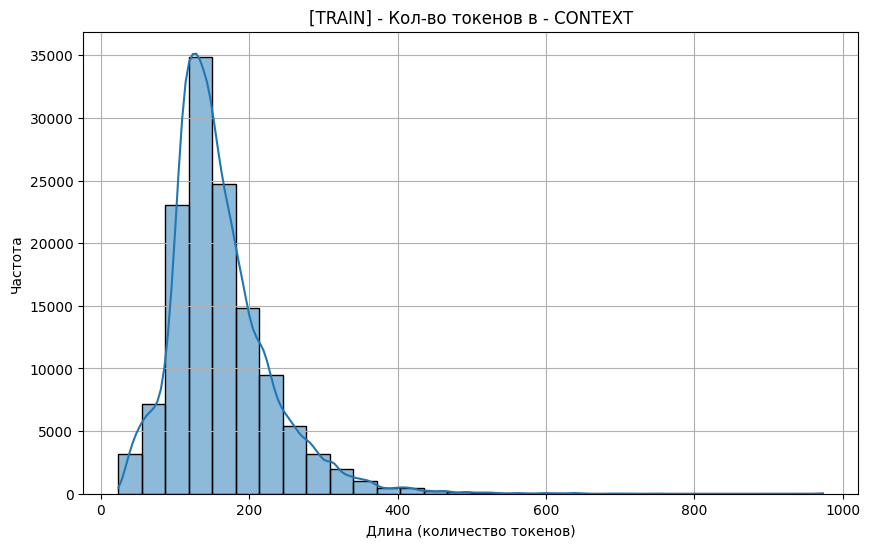

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset_prep['context_tokens_len'], bins=30, kde=True)  # kde=True добавляет кривую плотности
plt.title('[TRAIN] - Кол-во токенов в - CONTEXT')
plt.xlabel('Длина (количество токенов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

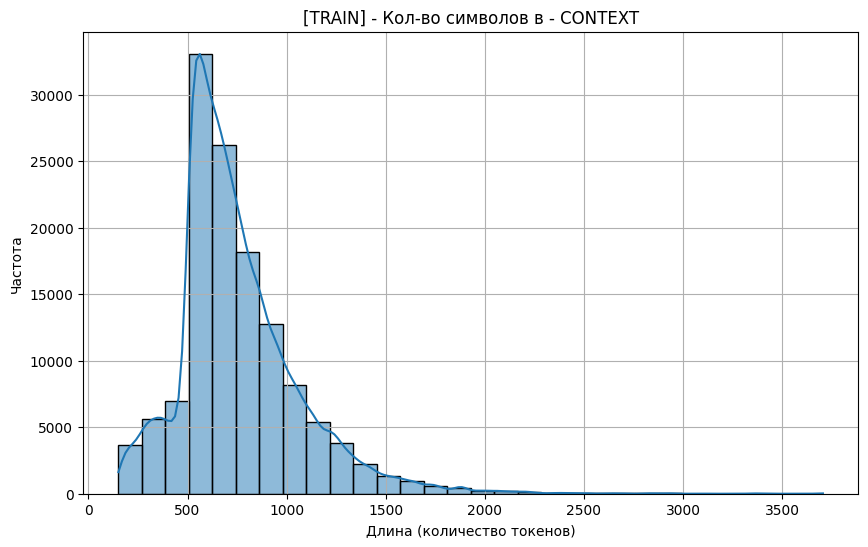

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset_prep['context_str_len'], bins=30, kde=True)  # kde=True добавляет кривую плотности
plt.title('[TRAIN] - Кол-во символов в - CONTEXT')
plt.xlabel('Длина (количество токенов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

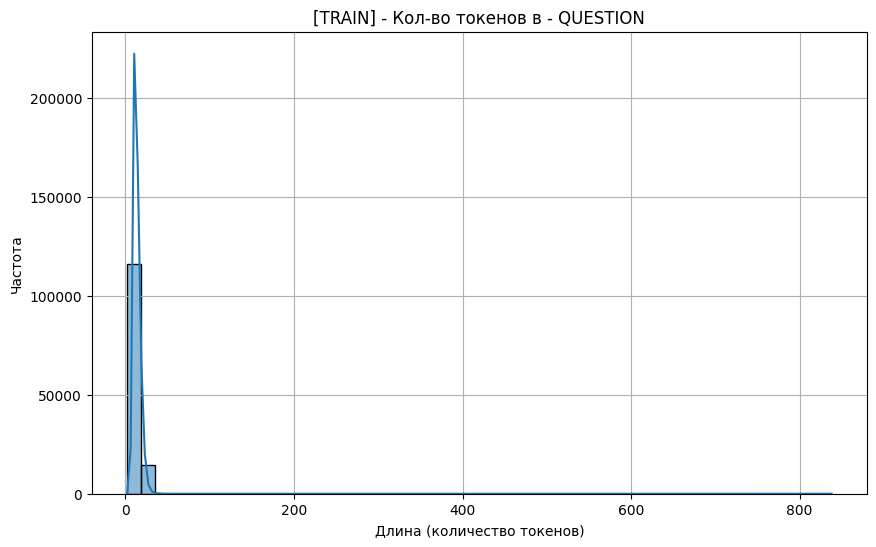

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset_prep['question_tokens_len'], bins=50, kde=True)  # kde=True добавляет кривую плотности
plt.title('[TRAIN] - Кол-во токенов в - QUESTION')
plt.xlabel('Длина (количество токенов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

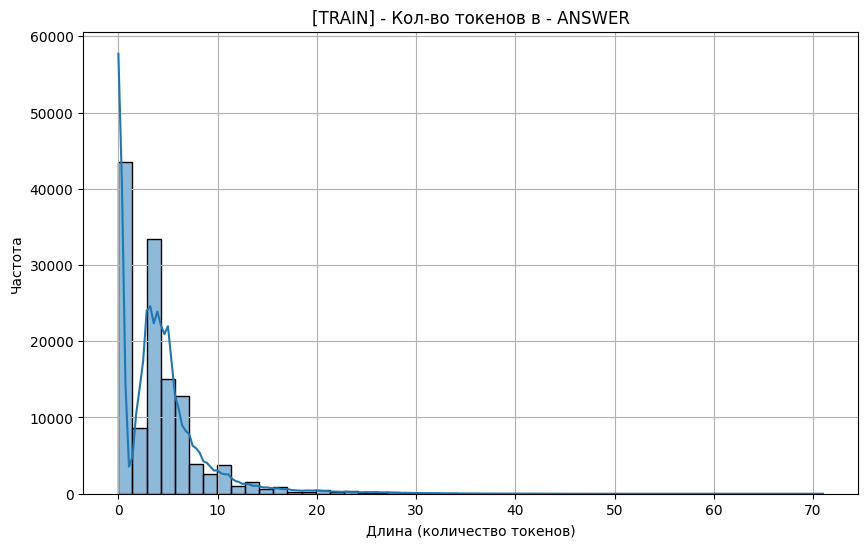

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset_prep['answers_tokens_len'], bins=50, kde=True)  # kde=True добавляет кривую плотности
plt.title('[TRAIN] - Кол-во токенов в - ANSWER')
plt.xlabel('Длина (количество токенов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

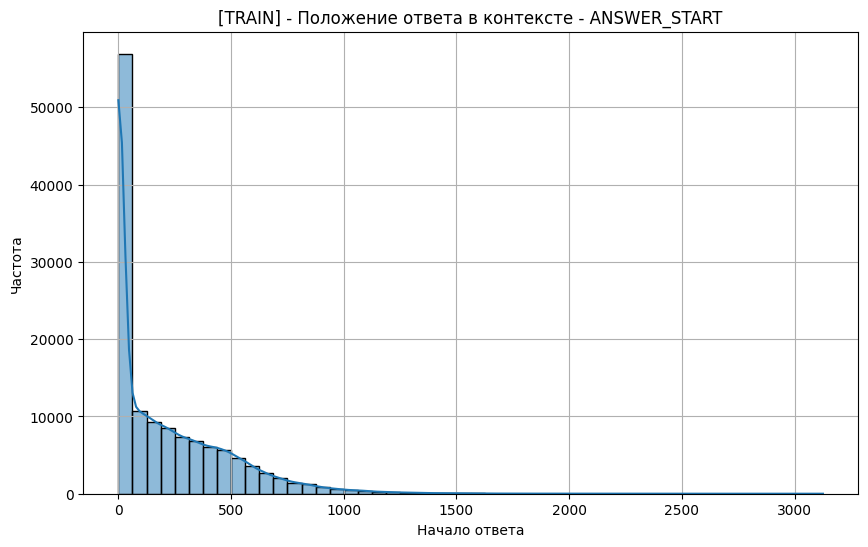

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(train_dataset_prep['answer_start'], bins=50, kde=True)  # kde=True добавляет кривую плотности
plt.title('[TRAIN] - Положение ответа в контексте - ANSWER_START')
plt.xlabel('Начало ответа')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

### VAL DATASET

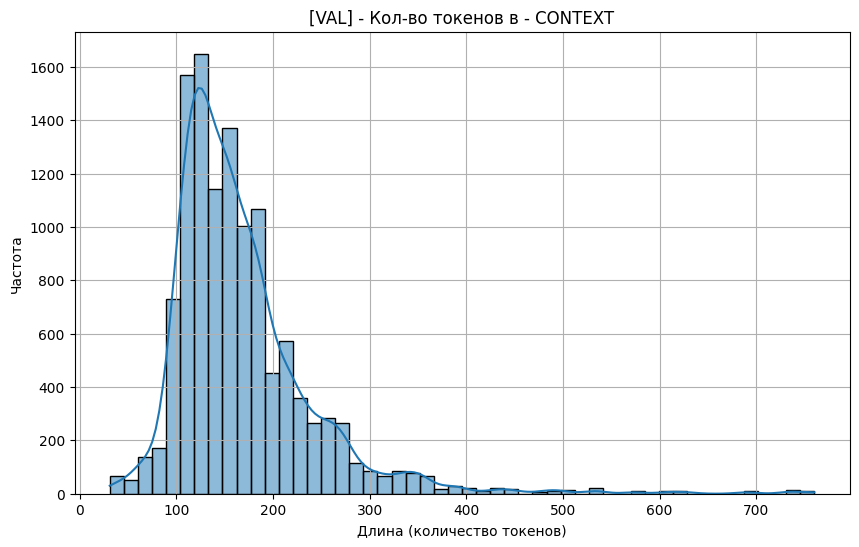

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(val_dataset_prep['context_tokens_len'], bins=50, kde=True)  # kde=True добавляет кривую плотности
plt.title('[VAL] - Кол-во токенов в - CONTEXT')
plt.xlabel('Длина (количество токенов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

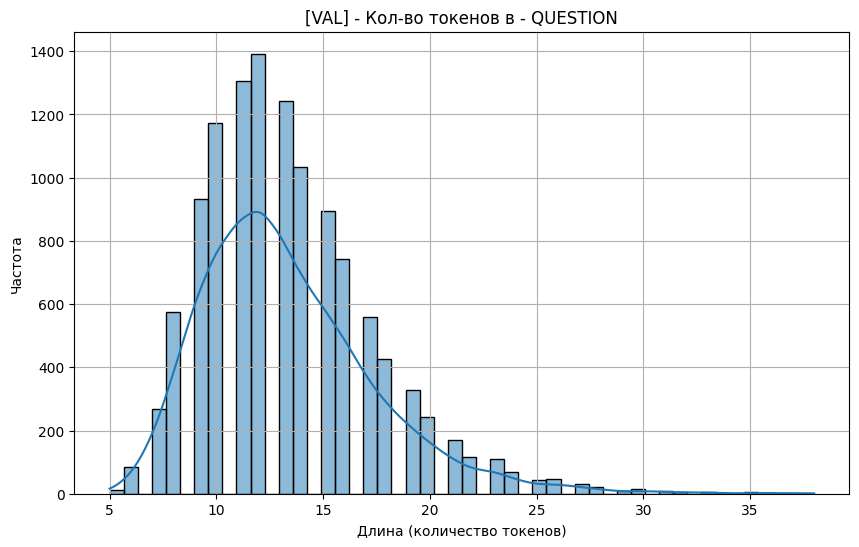

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(val_dataset_prep['question_tokens_len'], bins=50, kde=True)  # kde=True добавляет кривую плотности
plt.title('[VAL] - Кол-во токенов в - QUESTION')
plt.xlabel('Длина (количество токенов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

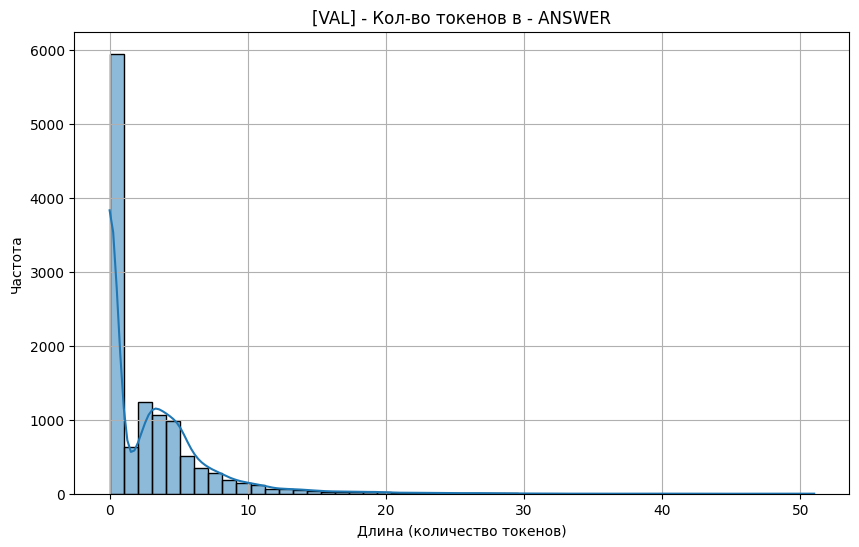

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(val_dataset_prep['answers_tokens_len'], bins=50, kde=True)  # kde=True добавляет кривую плотности
plt.title('[VAL] - Кол-во токенов в - ANSWER')
plt.xlabel('Длина (количество токенов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

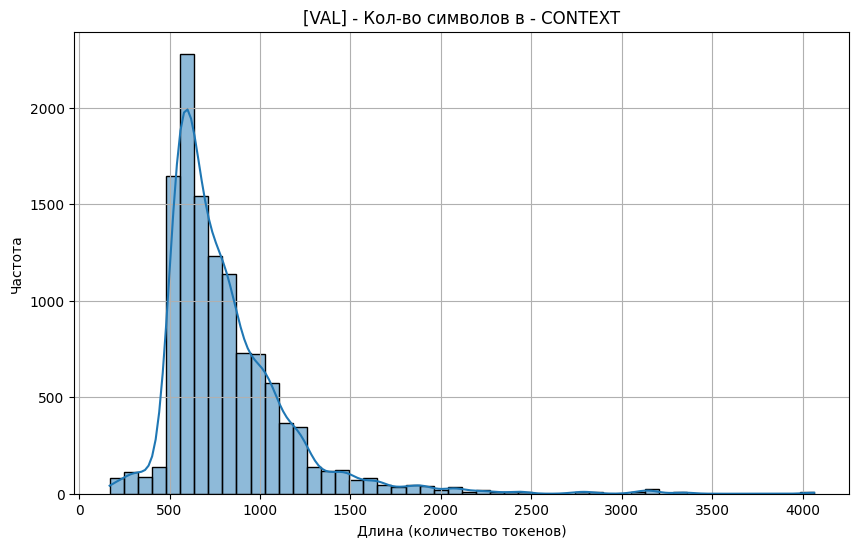

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(val_dataset_prep['context_str_len'], bins=50, kde=True)  # kde=True добавляет кривую плотности
plt.title('[VAL] - Кол-во символов в - CONTEXT')
plt.xlabel('Длина (количество токенов)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

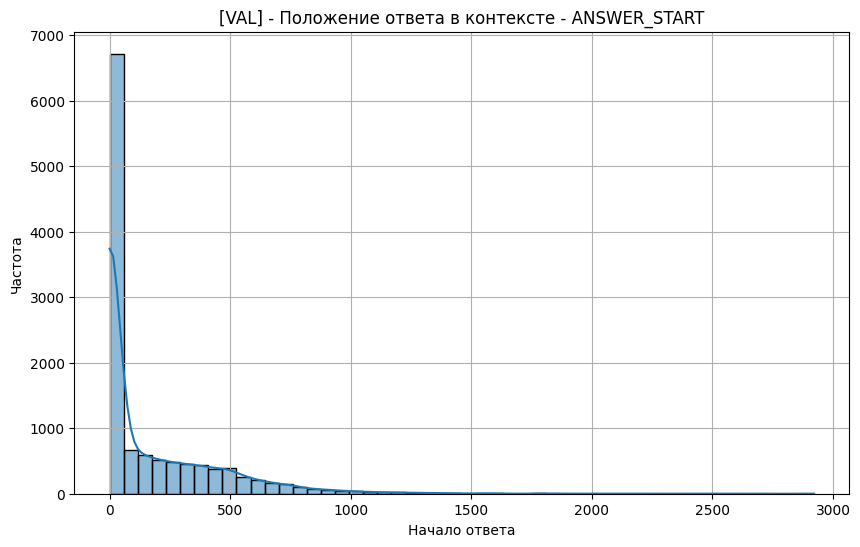

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(val_dataset_prep['answer_start'], bins=50, kde=True)  # kde=True добавляет кривую плотности
plt.title('[VAL] - Положение ответа в контексте - ANSWER_START')
plt.xlabel('Начало ответа')
plt.ylabel('Частота')
plt.grid(True)
plt.show()